In [110]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# Part 2
## Task 7

In [122]:
Q = np.array(
    [[-0.0085, 0.005, 0.0025, 0.0, 0.001],
     [0.0, -0.014, 0.005, 0.004, 0.005],
     [0.0, 0.0, -0.008, 0.003, 0.005],
     [0.0, 0.0, 0.0, -0.009, 0.009],
     [0.0, 0.0, 0.0, 0.0, 0.00]]
)

assert np.allclose(Q.sum(axis=1), 0), "Rows of Q should sum to zero"

P = np.zeros_like(Q)
for i in range(Q.shape[0]):
    if Q[i, i] != 0:
        P[i] = Q[i] / -Q[i, i]
        P[i, i] = 0  # Set diagonal to zero

assert np.allclose(P[:-1].sum(axis=1), 1), "Rows of P should sum to one"

# extract negative diagonal elements for easier indexing
q = -1 / np.diag(Q[:-1, :-1])

In [123]:
P, q

(array([[0.        , 0.58823529, 0.29411765, 0.        , 0.11764706],
        [0.        , 0.        , 0.35714286, 0.28571429, 0.35714286],
        [0.        , 0.        , 0.        , 0.375     , 0.625     ],
        [0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([117.64705882,  71.42857143, 125.        , 111.11111111]))

In [124]:
# Sampling time until next transition from state 2
print(np.random.exponential(q[2]))

# Sampling next state from state 2
print(np.random.choice([0, 1, 2, 3, 4], p=P[2]))

162.79767284745765
4


In [107]:
def plot_lifetimes(result_dict):
    lifetimes = result_dict["lifetimes"]
    plt.hist(lifetimes, bins=50, edgecolor='k', alpha=0.7)
    plt.xlabel("Lifetime (time units)")
    plt.ylabel("Number of women")
    plt.title("Distribution of lifetimes after surgery")
    plt.grid(True)
    plt.show()


In [126]:

def simulate_breast_cancer(womens: int):
    states = np.zeros(womens, dtype=int)
    sojourns = np.random.exponential(q[0], womens)
    lifetimes = np.zeros(womens)
    alive = np.ones(womens, dtype=bool)
    times = np.zeros(womens)

    with tqdm(total=womens, desc="Women dead") as pbar:
        while np.any(alive):
            active_indices = np.where(alive)[0]
            event = active_indices[np.argmin(sojourns[alive])]

            elapsed = sojourns[event]
            sojourns[alive] -= elapsed
            times[alive] += elapsed
            lifetimes[event] += elapsed

            new_state = np.random.choice(len(Q), p=P[states[event]])

            if new_state == 4:
                alive[event] = False
                pbar.update(1)
            else:
                states[event] = new_state
                sojourns[event] = np.random.exponential(q[new_state])

    return {"lifetimes": lifetimes}


np.random.seed(42)  # For reproducibility
results = simulate_breast_cancer(1000)

Women dead:   0%|          | 0/1000 [00:00<?, ?it/s]

Women dead: 100%|██████████| 1000/1000 [00:00<00:00, 1373.23it/s]


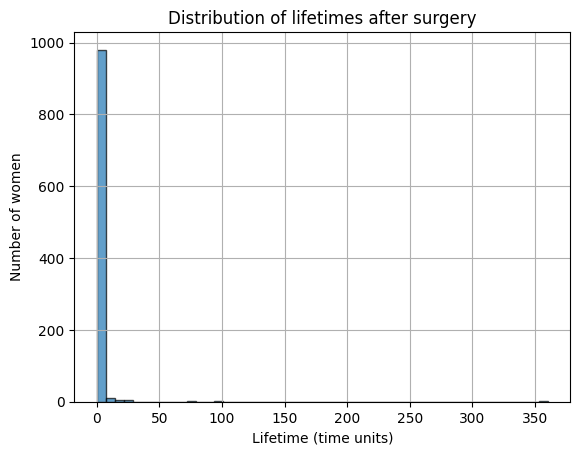

In [127]:
plot_lifetimes(results)

In [128]:
def report_lifetime_statistics(lifetimes, confidence=0.95):
    n = len(lifetimes)
    mean = np.mean(lifetimes)
    std = np.std(lifetimes, ddof=1)

    z = norm.ppf(1 - (1 - confidence) / 2)
    se_mean = std / np.sqrt(n)
    se_std = std / np.sqrt(2 * (n - 1))  # Approximate SE of sample std

    ci_mean = (mean - z * se_mean, mean + z * se_mean)
    ci_std = (std - z * se_std, std + z * se_std)

    print(f"Mean lifetime: {mean:.2f} (95% CI: {ci_mean[0]:.2f} – {ci_mean[1]:.2f})")
    print(f"Standard deviation: {std:.2f} (95% CI: {ci_std[0]:.2f} – {ci_std[1]:.2f})")

report_lifetime_statistics(results["lifetimes"], confidence=0.95)


Mean lifetime: 1.45 (95% CI: 0.70 – 2.21)
Standard deviation: 12.18 (95% CI: 11.64 – 12.71)


In [130]:
# In what proportion of women has the cancer reappeared distantly after 30.5 months?
def proportion_cancer_reappeared(lifetimes, threshold=30.5):
    return np.sum(lifetimes > threshold) / len(lifetimes)
print(f"Proportion of women with distant cancer reappearance after 30.5 months: {proportion_cancer_reappeared(results['lifetimes']):.2%}")

Proportion of women with distant cancer reappearance after 30.5 months: 0.30%
